# Evaluating Neural Networks Core
**Student:** Matthew Malueg

### Task

Build a neural network using data from a kaggle competition. To complete the assignment, train and evaluate a model using only the train.csv.

Remember, with Kaggle competitions; the test.csv does not include values for the target! The test.csv is only used for the competition, and you cannot evaluate your model using the test.csv without submitting your predictions to Kaggle.

**Complete the following:**
1. Perform a train test split on train.csv to evaluate the models.
2. Create 3 iterations of a deep learning model to predict housing prices using learned techniques to optimize model performance. Include some type of regularization with at least one model.
3. Select the best performing model!


### Imports, Functions, Loading

In [1]:
# imports
import pandas as pd
import seaborn as sns
import missingno as msno

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, ConfusionMatrixDisplay, mean_squared_error, r2_score, mean_absolute_error)

# Keras
from tensorflow import keras
from keras.layers import Dense
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
pd.options.display.max_rows = 100

In [2]:
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

In [3]:
# load data
df = pd.read_csv('Data/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df = df.set_index('Id')

### Explore Data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [6]:
df.duplicated().sum()

0

In [7]:
df.isna().sum()

MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea 

In [8]:
for col in df.columns:
    if df[col].isna().sum() > 0:
        n_missing = df[col].isna().sum()
        print(f'{col} is missing {n_missing}/{df.shape[0]} values, or {round((df[col].isna().sum() / df.shape[0] * 100), 2)}%.\n')

LotFrontage is missing 259/1460 values, or 17.74%.

Alley is missing 1369/1460 values, or 93.77%.

MasVnrType is missing 8/1460 values, or 0.55%.

MasVnrArea is missing 8/1460 values, or 0.55%.

BsmtQual is missing 37/1460 values, or 2.53%.

BsmtCond is missing 37/1460 values, or 2.53%.

BsmtExposure is missing 38/1460 values, or 2.6%.

BsmtFinType1 is missing 37/1460 values, or 2.53%.

BsmtFinType2 is missing 38/1460 values, or 2.6%.

Electrical is missing 1/1460 values, or 0.07%.

FireplaceQu is missing 690/1460 values, or 47.26%.

GarageType is missing 81/1460 values, or 5.55%.

GarageYrBlt is missing 81/1460 values, or 5.55%.

GarageFinish is missing 81/1460 values, or 5.55%.

GarageQual is missing 81/1460 values, or 5.55%.

GarageCond is missing 81/1460 values, or 5.55%.

PoolQC is missing 1453/1460 values, or 99.52%.

Fence is missing 1179/1460 values, or 80.75%.

MiscFeature is missing 1406/1460 values, or 96.3%.



<Axes: >

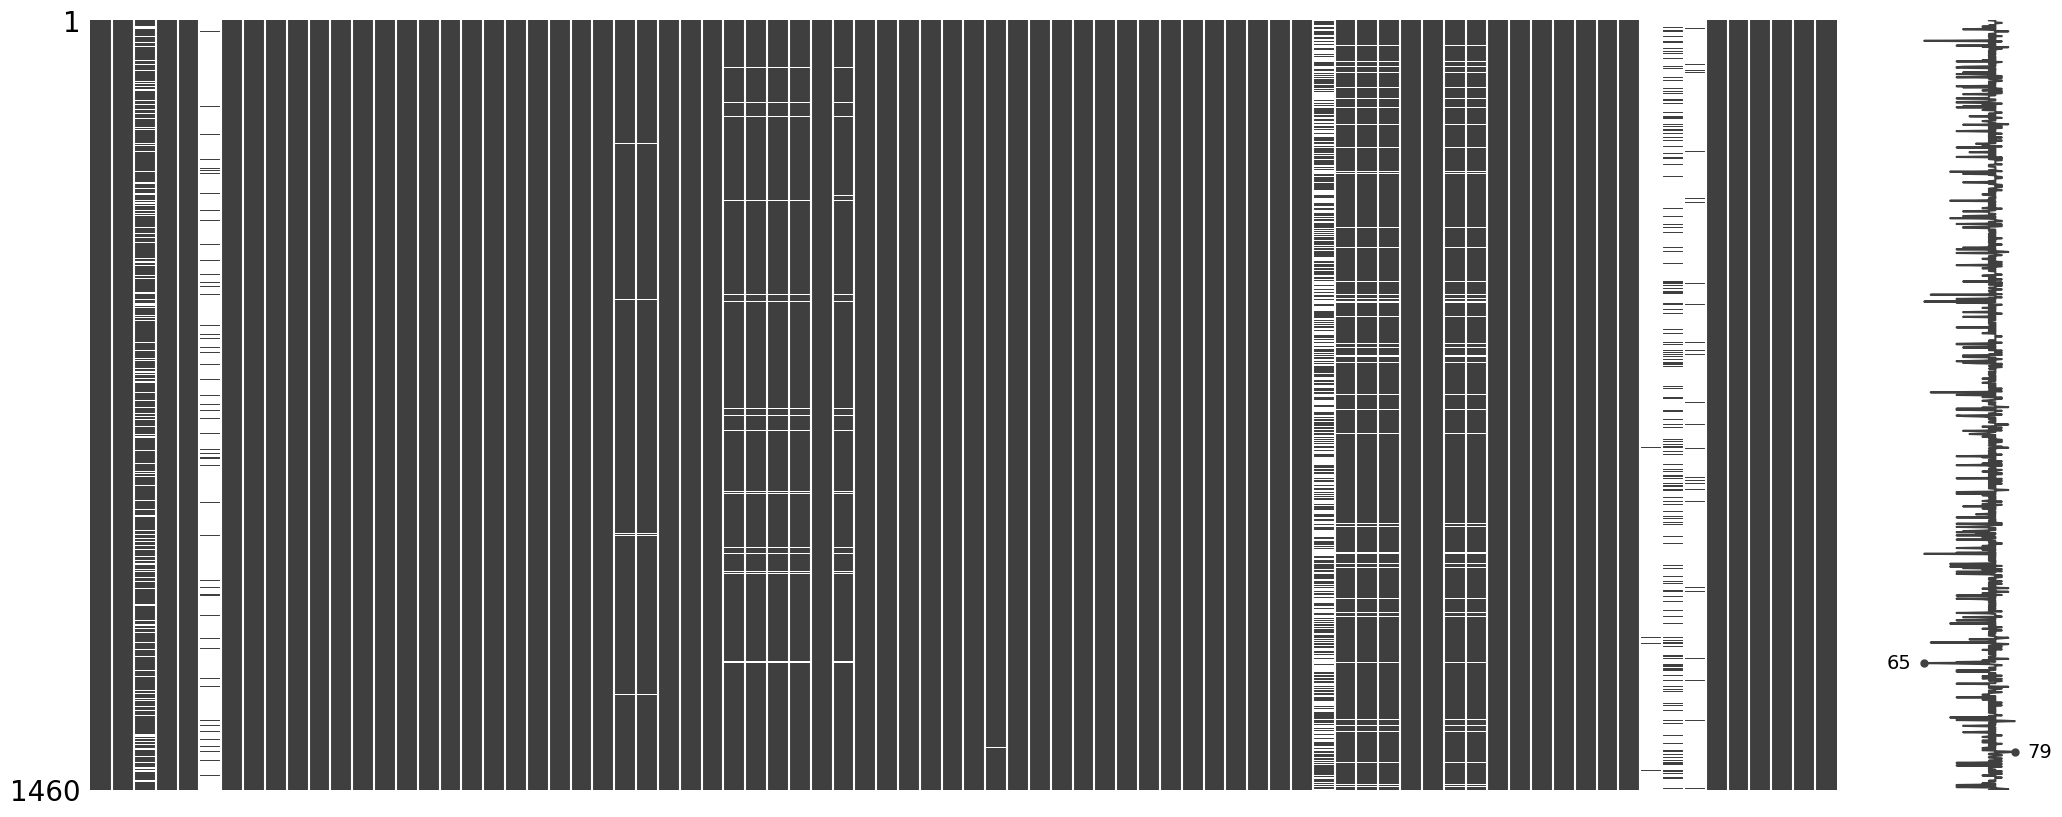

In [9]:
# Check missing values for patterns
msno.matrix(df)

**Missing Values**
- There look to specific rows that are missing the same cluster of features, for instance information on a garage or basement. The patterns suggest this is a result of the feature not being present.
- We can impute these values as zero/none during preprocessing.

### Preprocess and Train Test Split

In [10]:
# Assign target and features
y = df['SalePrice']
X = df.drop(columns='SalePrice')

# Perform TTS
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [11]:
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1024,120,RL,43.0,3182,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal
811,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,648,Fa,GdPrv,NaN,0,1,2006,WD,Normal
1385,50,RL,60.0,9060,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,10,2009,WD,Normal
627,20,RL,NaN,12342,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,GdWo,Shed,600,8,2007,WD,Normal
814,20,RL,75.0,9750,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,Shed,500,4,2007,COD,Normal


In [12]:
## Create Preprocessor
# Select columns
cat_cols = X_train.select_dtypes('object').columns
num_cols = X_train.select_dtypes('number').columns

In [13]:
## Initialize scaler and imputer
# Categotical 
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe_imputer = SimpleImputer(strategy='constant', fill_value='None')

# Numerical
scaler = StandardScaler()
num_imputer = SimpleImputer(strategy='constant', fill_value=0)

In [14]:
# Create Pipelines
cat_pipe = make_pipeline(ohe_imputer, ohe)
num_pipe = make_pipeline(num_imputer, scaler)

# Create tuples
cat_tuple = ('cat', cat_pipe, cat_cols)
num_tuple = ('num', num_pipe, num_cols)

In [15]:
# Create preprocessor object
preprocessor = ColumnTransformer([num_tuple, cat_tuple], remainder='passthrough', sparse_threshold=0.5)

In [16]:
# Preprocess data
X_train_tf = preprocessor.fit_transform(X_train)
X_test_tf = preprocessor.transform(X_test)

### Model 1

In [17]:
# Get input shape
input_shape = X_train_tf.shape[1]
input_shape

299

In [18]:
# Sequential model
model = keras.Sequential()

model.add(Dense(60, input_dim=input_shape, activation ='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mse', optimizer = 'adam'
              , metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                18000     
                                                                 
 dense_1 (Dense)             (None, 30)                1830      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 19,861
Trainable params: 19,861
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Fit model
history = model.fit(X_train_tf, y_train,
                    validation_split = .2, epochs=200, verbose=False)

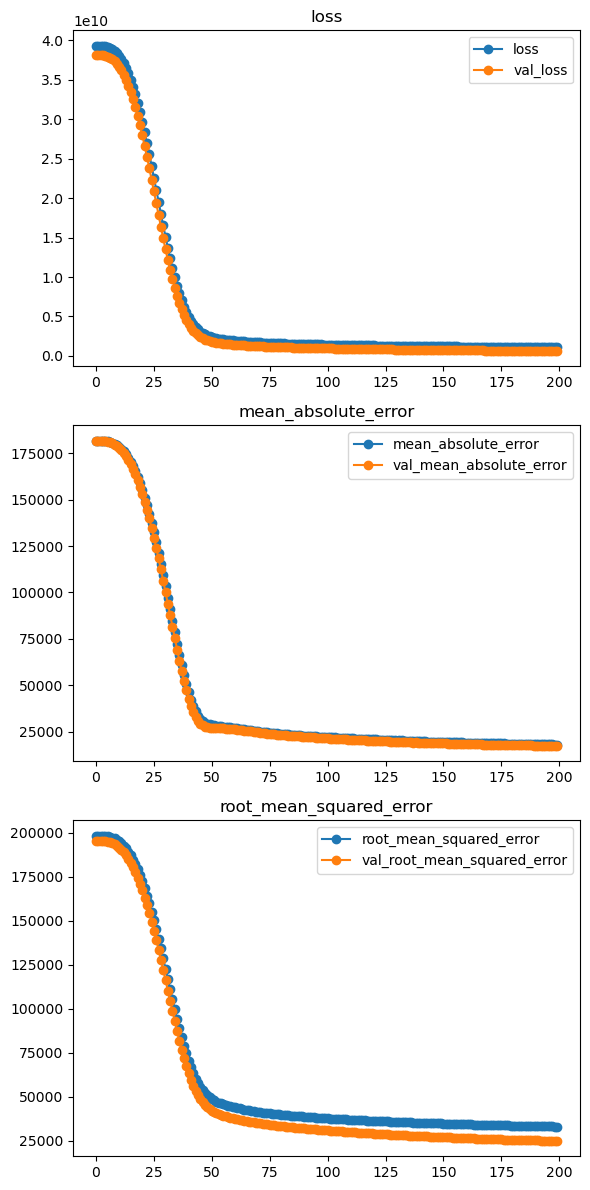

In [20]:
# plot learning 
plot_history(history);

In [21]:
# Evaluate model
y_pred = model.predict(X_test_tf)
print(f'Final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'Final R2: {r2_score(y_test, y_pred)}')

12/12 [==============================] - 0s 4ms/step
Final MAE: 19225.50390625
Final R2: 0.851346455212872


This model is performing alright so far, with an R2 score of 85%. It doesn't appear to be overfitting at all, so maybe adding some complexity will help increase it's performance.

### Model 2

In [22]:
# Sequential model
model = keras.Sequential()

# Hidden layers
model.add(Dense(60, input_dim=input_shape, activation ='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dropout(.3))
model.add(Dense(30, activation='relu'))
model.add(Dropout(.3))
# Output layer
model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mse', optimizer = 'adam'
              , metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 60)                18000     
                                                                 
 dense_4 (Dense)             (None, 30)                1830      
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_5 (Dense)             (None, 30)                930       
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 31        
                                                                 
Total params: 20,791
Trainable params: 20,791
Non-trai

In [23]:
# Fit model
history = model.fit(X_train_tf, y_train,
                    validation_split = .2, 
                    epochs=200, 
                    verbose=False)

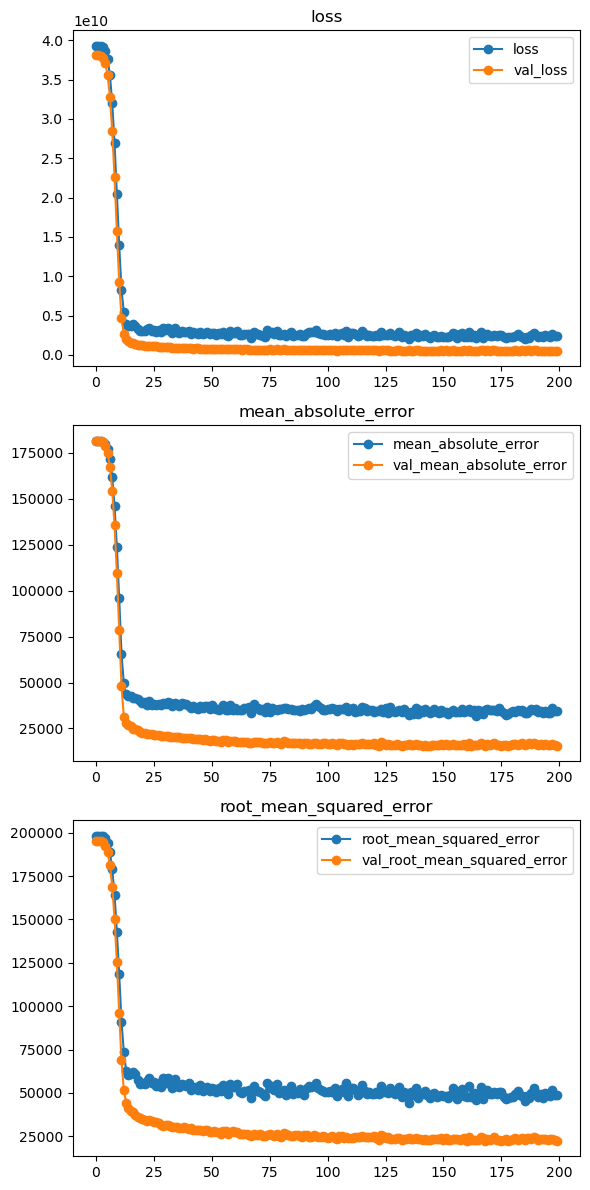

In [24]:
# Plot learning history
plot_history(history);

In [25]:
# Evaluate model
y_pred = model.predict(X_test_tf)
print(f'Final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'Final R2: {r2_score(y_test, y_pred)}')

12/12 [==============================] - 0s 781us/step
Final MAE: 18749.18193493151
Final R2: 0.8672821287452253


The scores did not change very much, although the model did seem to level off sooner. Also of note is that the model had better performance on the validation data, but the test data seemed to do a little worse. The model could also likely be stopped earlier.

### Model 3

In [26]:
# Sequential model
model = keras.Sequential()

# Hidden layers
model.add(Dense(80, input_dim=input_shape, activation ='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(40, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(10, activation='relu'))
model.add(Dropout(.3))
# Output layer
model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mse', optimizer = 'adam'
              , metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 80)                24000     
                                                                 
 dense_8 (Dense)             (None, 40)                3240      
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 dense_9 (Dense)             (None, 40)                1640      
                                                                 
 dropout_3 (Dropout)         (None, 40)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                410       
                                                                 
 dropout_4 (Dropout)         (None, 10)               

In [27]:
# Define early stopping callback
early_stop = EarlyStopping(monitor='loss', patience=5)

In [28]:
# Fit model
history = model.fit(X_train_tf, y_train,
                    validation_split = .2, 
                    epochs=200, 
                    verbose=False, callbacks=[early_stop])

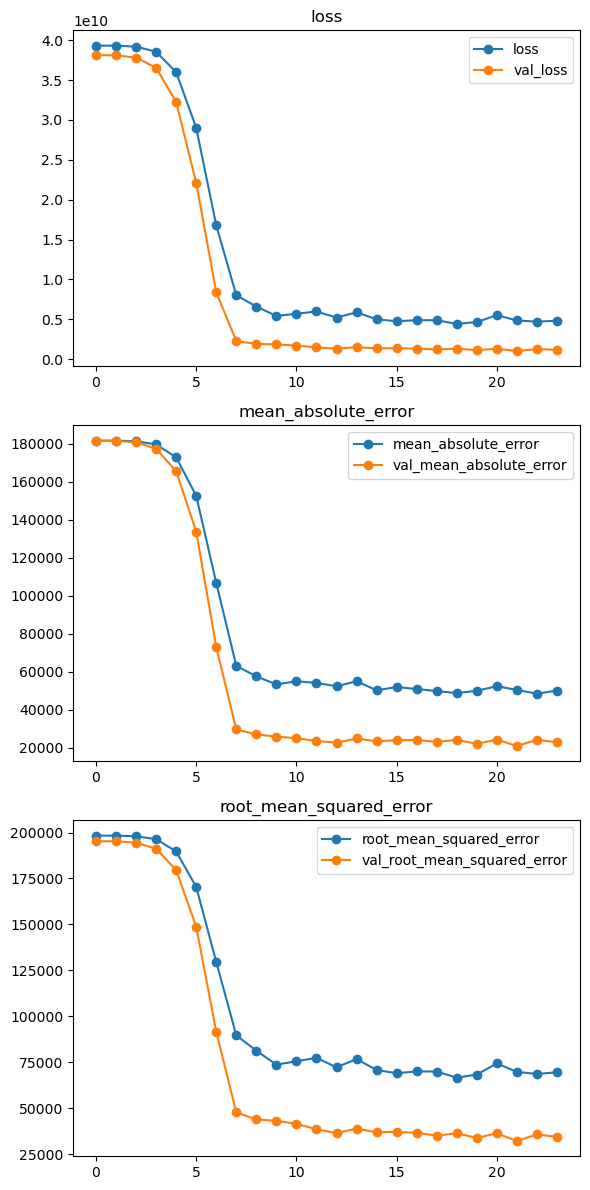

In [29]:
# Plot learning history
plot_history(history);

In [30]:
# Evaluate model
y_pred = model.predict(X_test_tf)
print(f'Final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'Final R2: {r2_score(y_test, y_pred)}')

12/12 [==============================] - 0s 2ms/step
Final MAE: 25151.325486943493
Final R2: 0.7456359162865924


This model stopped sooner, but didn't increase it's performance at all. In fact, the metrics decreased. Let's try running Model 2 one more time, but including the early stop.

### Model 4

In [38]:
# Sequential model
model = keras.Sequential()

# Hidden layers
model.add(Dense(60, input_dim=input_shape, activation ='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dropout(.3))
model.add(Dense(30, activation='relu'))
model.add(Dropout(.3))
# Output layer
model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mse', optimizer = 'adam'
              , metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 60)                18000     
                                                                 
 dense_17 (Dense)            (None, 30)                1830      
                                                                 
 dropout_7 (Dropout)         (None, 30)                0         
                                                                 
 dense_18 (Dense)            (None, 30)                930       
                                                                 
 dropout_8 (Dropout)         (None, 30)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 31        
                                                                 
Total params: 20,791
Trainable params: 20,791
Non-trai

In [39]:
# Define early stopping callback
early_stop = EarlyStopping(monitor='loss', patience=10)

In [40]:
# Fit model
history = model.fit(X_train_tf, y_train,
                    validation_split = .2, 
                    epochs=200, 
                    verbose=False, callbacks=[early_stop])

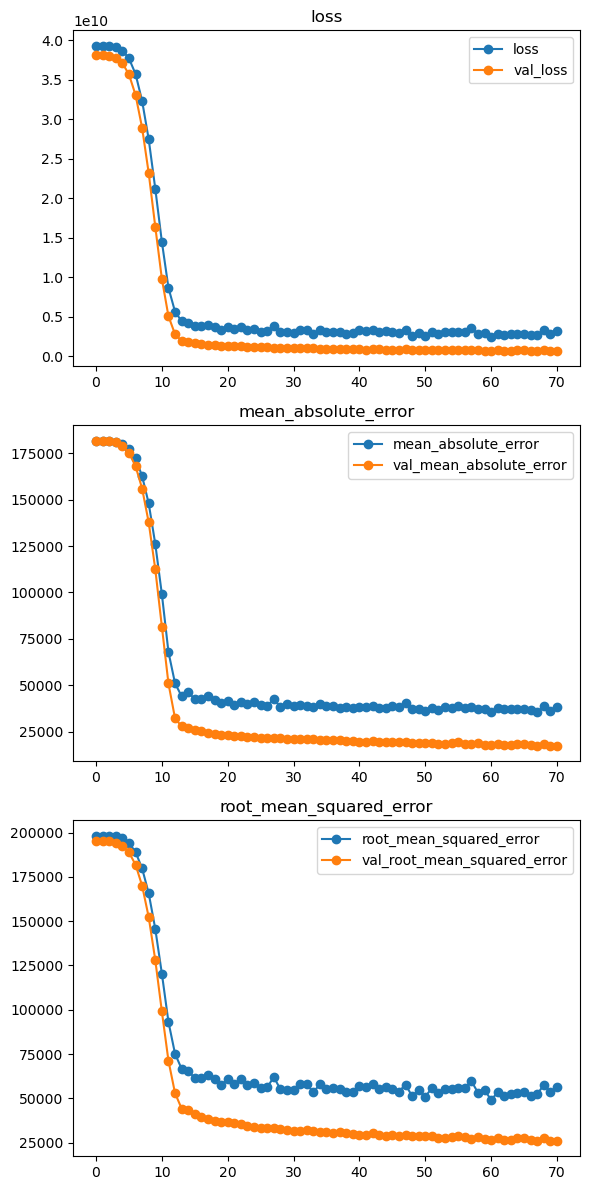

In [41]:
# Plot learning history
plot_history(history);

In [42]:
# Evaluate model
y_pred = model.predict(X_test_tf)
print(f'Final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'Final R2: {r2_score(y_test, y_pred)}')

12/12 [==============================] - 0s 820us/step
Final MAE: 19601.650395976027
Final R2: 0.8368276740456982


### Selecting a Model

I would select Model 2 as a final choice. It has the best metrics, with an R2 of around 86% and mean error in estimating home price of about $19,000. Adding additional complexity by adding more layers or early stopping did not improve the performance of the model noticably, although the early stopping did reduce the number of epochs by about half. If time were being prioritized, Model 4 may be a slightly better choice.